## Generation of synthetic data

This scripts generates parameter vectors, and simulates a training and test set with the VERDICT modelling. Simulations is done with the dmipy modelling framework [1].

[1] Rutger Fick, Rachid Deriche, & Demian Wassermann. (2019, October 15). The Dmipy Toolbox: Diffusion MRI Multi-Compartment Modeling and Microstructure Recovery Made Easy (Version 1.0). Zenodo. http://doi.org/10.5281/zenodo.3490325


## Loading the VERDICT MODEL 

\begin{equation}
 E_{\textrm{VERDICT}}= \underbrace{f_{\textrm{Tumor}}\overbrace{E(D|\lambda_{\textrm{intra}})}^{\textrm{Sphere}}}_{\textrm{Tumor Cells}} + \underbrace{f_{\textrm{extra}}\overbrace{E(\cdot|\lambda_{iso})}^{\textrm{Ball}}}_{\textrm{Hindered Extra-Cellular}}+\underbrace{f_{blood}\overbrace{E(\lambda_\parallel, \boldsymbol{\mu})}^{\textrm{Stick}}}_{\textrm{Vascular}}
\end{equation}

In [247]:
from dmipy.signal_models import sphere_models, cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel
import numpy as np

sphere = sphere_models.S4SphereGaussianPhaseApproximation(diffusion_constant=1.2e-9)
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()

verdict_mod = MultiCompartmentModel(models=[sphere, ball, stick])

verdict_mod.set_fixed_parameter('G1Ball_1_lambda_iso', 2e-9) #2
verdict_mod.set_fixed_parameter('C1Stick_1_lambda_par',8e-9)
verdict_mod.set_fixed_parameter('C1Stick_1_mu',[1.570796326794897,0])


## Loading acquisition scheme

In [248]:
from dmipy.core.acquisition_scheme import acquisition_scheme_from_schemefile
from os.path import join

acquisition_path = "/Users/theavage/Documents/Master/Master-Project/data/145.scheme"

scheme= acquisition_scheme_from_schemefile(acquisition_path)

## Creating parameter arrays

With random values of R and the IC,EES and VASC volume fractions

In [250]:
def all_comb(ic,ec,vasc,radi):
    """
    Finds all combinations of volume fractions and radius ranges,
    with volume fractions summing to one. 
    """

    comb= []

    for i in ic:
        for j in ec:
            for k in vasc:
                if i+j+k == 1:
                    for r in radi:
                        for l in range(10):
                            comb.append([r,i,j,k])
    return comb

#Creating parameter ranges
ranges = np.arange(0.1,1.1,0.1)
ic = ranges; ec = ranges; vasc = ranges
radi = np.arange(2e-6,15e-6,0.5e-6)*2

#Creating parameter vector
all_combinations = all_comb(ic,ec,vasc,radi)
parameter_vector = np.array(all_combinations)

## Simulating new data from simulated parameter vector

In [7]:
simulated_signal = verdict_mod.simulate_signal(scheme,parameter_vector)
np.save('simulated_9180_160.npy',simulated_signal)

## Visualization of simulated data

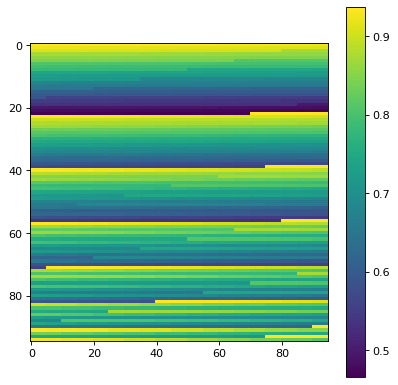

In [15]:
from matplotlib import pyplot as plt

plt.figure(figsize=(6,6),dpi=80)
plt.imshow(simulated_signal[:95*95].reshape(95,95,160)[:,:,6])
plt.colorbar()


## Simulating test data

In [243]:
# define parameter values in the three regions
r_region0, r_region1, r_region2 = 10e-6, 20e-6, 30e-6
f_sphere_region0, f_sphere_region1, f_sphere_region2 = 0.2, 0.4, 0.8
f_ball_region0, f_ball_region1, f_ball_region2 = 0.6, 0.2, 0.1
f_stick_region0, f_stick_region1, f_stick_region2 = 0.2, 0.4, 0.1

# image size
sx, sy, sb = 50, 50, len(scheme.bvalues)
# create image
dwi_image = np.zeros((sx, sy, sb))
r_truth = np.zeros((sx, sy))
f_sphere_truth = np.zeros((sx, sy))
f_ball_truth = np.zeros((sx, sy))
f_stick_truth = np.zeros((sx, sy))

# fill image with simulated values
for i in range(sx):
    for j in range(sy):
        if (20 < i < 30) and (20 < j < 30):
            dwi_image[i, j, :] = verdict_mod.simulate_signal(scheme, np.array([r_region0,f_sphere_region0,f_ball_region0,f_stick_region0]))
            r_truth[i, j], f_sphere_truth[i, j], f_ball_truth[i, j], f_stick_truth[i, j] = r_region0, f_sphere_region0, f_ball_region0, f_stick_region0
        elif (10 < i < 40) and (10 < j < 40):
            dwi_image[i, j, :] = verdict_mod.simulate_signal(scheme, np.array([r_region1,f_sphere_region1,f_ball_region1,f_stick_region1]))
            r_truth[i, j], f_sphere_truth[i, j], f_ball_truth[i, j], f_stick_truth[i, j] = r_region1, f_sphere_region1, f_ball_region1, f_stick_region1
        else:
            dwi_image[i, j, :] =verdict_mod.simulate_signal(scheme, np.array([r_region2,f_sphere_region2,f_ball_region2,f_stick_region2]))
            r_truth[i, j], f_sphere_truth[i, j], f_ball_truth[i, j], f_stick_truth[i, j] = r_region2, f_sphere_region2, f_ball_region2, f_stick_region2


In [ ]:
np.save('simulated_2500.npy',dwi_image)